## Title Cell

In [592]:
# Import dependencies
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import warnings
warnings.filterwarnings('ignore')

In [618]:
# Import csv, convert to a dataframe. List the columns so we know how to clean it up
diabetes_csv = pd.read_csv("source_data/diabetes_indicators.csv")
diabetes_df = pd.DataFrame(diabetes_csv)
diabetes_df.columns

Index(['Diabetes_012', 'HighBP', 'HighChol', 'CholCheck', 'BMI', 'Smoker',
       'Stroke', 'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies',
       'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'GenHlth',
       'MentHlth', 'PhysHlth', 'DiffWalk', 'Sex', 'Age', 'Education',
       'Income'],
      dtype='object')

## William

In [111]:
# Trim the dataframe so it is only our variables of interest
df_trimmed = diabetes_df[["Diabetes_012", "Income", "Education", "Age", "HvyAlcoholConsump", "Fruits", "Veggies", "CholCheck", "HighChol", "PhysActivity", "BMI"]].copy()
df_trimmed.head()

,Diabetes_012,Income,Education,Age,HvyAlcoholConsump,Fruits,Veggies,CholCheck,HighChol,PhysActivity,BMI
0,0.0,3.0,4.0,9.0,0.0,0.0,1.0,1.0,1.0,0.0,40.0
1,0.0,1.0,6.0,7.0,0.0,0.0,0.0,0.0,0.0,1.0,25.0
2,0.0,8.0,4.0,9.0,0.0,1.0,0.0,1.0,1.0,0.0,28.0
3,0.0,6.0,3.0,11.0,0.0,1.0,1.0,1.0,0.0,1.0,27.0
4,0.0,4.0,5.0,11.0,0.0,1.0,1.0,1.0,1.0,1.0,24.0


In [112]:
# Group by fruit consumption and diabetes status, count the number of participants for each category
dia_fruits = df_trimmed.groupby(["Fruits", "Diabetes_012"]).size().reset_index(name='count')

# ***(I think we could also use a .loc here to make it easier - but this works)***
# Separate 0 fruit values from 1 fruit values, copying the tables so we can easily perform actions on them
nofruits = dia_fruits[dia_fruits["Fruits"] == 0].copy()
yesfruits = dia_fruits[dia_fruits["Fruits"] == 1].copy()

# Find the total respondents per category (fruit and no fruit)
# Create a new column for the proportion of respondents in each row out of their respective category
nofruits_sum = nofruits["count"].sum()
nofruits["proportion"] = (nofruits["count"] / nofruits_sum) * 100

yesfruits_sum = yesfruits["count"].sum()
yesfruits["proportion"] = (yesfruits["count"] / yesfruits_sum) * 100

# Using the pd.concat() function, combine the two tables into the new fruitstack df, which shows the proportions
fruitstack = pd.concat([nofruits, yesfruits], ignore_index=False)
fruitstack




,Fruits,Diabetes_012,count,proportion
0,0.0,0.0,76287,82.221767
1,0.0,1.0,1842,1.985299
2,0.0,2.0,14653,15.792934
3,1.0,0.0,137416,85.405661
4,1.0,1.0,2789,1.733396
5,1.0,2.0,20693,12.860943


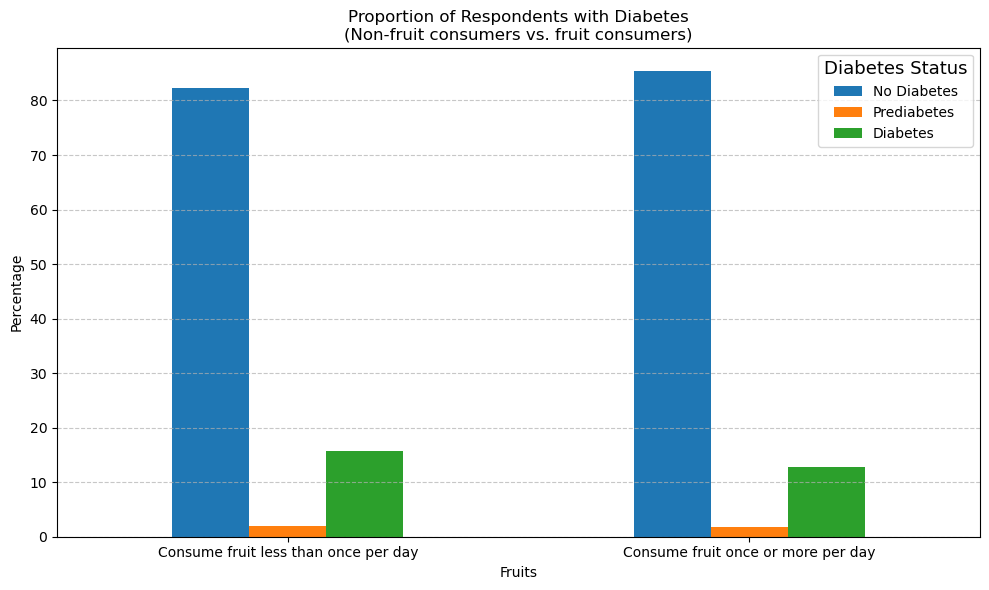

In [113]:
# Set up pivot table to reorganize fruitstack df
pivot_df = fruitstack.pivot(index='Fruits', columns='Diabetes_012', values='proportion')

# Rename columns for easy display formatting
pivot_df.columns = ['No Diabetes', 'Prediabetes', 'Diabetes']


# Rename indices for easy display formatting
index_mapping = {0.0: 'Consume fruit less than once per day', 1.0: 'Consume fruit once or more per day'}
pivot_df.index = pivot_df.index.map(index_mapping)

# Plot the table
pivot_df.plot(kind='bar', figsize=(10, 6))
plt.title('Proportion of Respondents with Diabetes\n(Non-fruit consumers vs. fruit consumers)')
plt.xlabel('Fruits')
plt.ylabel('Percentage')
plt.xticks(ticks=range(len(pivot_df.index)), labels=pivot_df.index, rotation=0)
plt.legend(title='Diabetes Status', title_fontsize='13')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## Chinna

## Abigail

## Muad

## Sophia

In [118]:
diabetes_df.columns

Index(['Diabetes_012', 'HighBP', 'HighChol', 'CholCheck', 'BMI', 'Smoker',
       'Stroke', 'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies',
       'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'GenHlth',
       'MentHlth', 'PhysHlth', 'DiffWalk', 'Sex', 'Age', 'Education',
       'Income'],
      dtype='object')

In [119]:
# Trim the dataframe so it is only our variables of interest
df_trimmed = diabetes_df[["Diabetes_012", "Income", "Education", "Age", "HvyAlcoholConsump", "Fruits", "Veggies", "CholCheck", "HighChol", "PhysActivity", "BMI"]].copy()
df_trimmed.head()

,Diabetes_012,Income,Education,Age,HvyAlcoholConsump,Fruits,Veggies,CholCheck,HighChol,PhysActivity,BMI
0,0.0,3.0,4.0,9.0,0.0,0.0,1.0,1.0,1.0,0.0,40.0
1,0.0,1.0,6.0,7.0,0.0,0.0,0.0,0.0,0.0,1.0,25.0
2,0.0,8.0,4.0,9.0,0.0,1.0,0.0,1.0,1.0,0.0,28.0
3,0.0,6.0,3.0,11.0,0.0,1.0,1.0,1.0,0.0,1.0,27.0
4,0.0,4.0,5.0,11.0,0.0,1.0,1.0,1.0,1.0,1.0,24.0


In [389]:
# Group by heavy alcohol consumption and diabetes status, count the number of participants for each category
alcohol_vs_diabetes = df_trimmed.groupby(["HvyAlcoholConsump", "Diabetes_012"]).size().reset_index(name='count')
alcohol_vs_diabetes
# Separate 0 fruit values from 1 fruit values, copying the tables so we can easily perform actions on them
no_alc = alcohol_vs_diabetes[alcohol_vs_diabetes["HvyAlcoholConsump"] == 0].copy()
yes_alc = alcohol_vs_diabetes[alcohol_vs_diabetes["HvyAlcoholConsump"] == 1].copy()

# Find the total respondents per category (fruit and no fruit)
# Create a new column for the proportion of respondents in each row out of their respective category
no_alc_sum = no_alc["count"].sum()
no_alc["proportion"] = (no_alc["count"] / no_alc_sum) * 100

yes_alc_sum = yes_alc["count"].sum()
yes_alc["proportion"] = (yes_alc["count"] / yes_alc_sum) * 100

# Using the pd.concat() function, combine the two tables into the new fruitstack df, which shows the proportions
alcoholstack = pd.concat([no_alc, yes_alc], ignore_index=False)
alcoholstack



,HvyAlcoholConsump,Diabetes_012,count,proportion
0,0.0,0.0,200487,83.737219
1,0.0,1.0,4423,1.847350
2,0.0,2.0,34514,14.415430
3,1.0,0.0,13216,92.704826
4,1.0,1.0,208,1.459035
5,1.0,2.0,832,5.836139


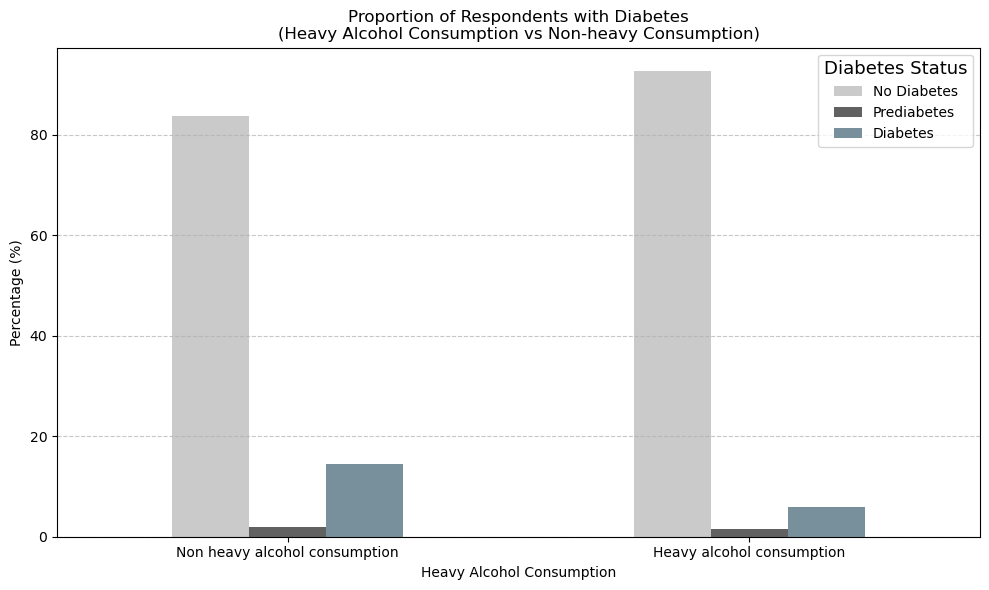

In [616]:
# Set up pivot table to reorganize fruitstack df
alc_pivot_df =alcoholstack.pivot(index='HvyAlcoholConsump', columns='Diabetes_012', values='proportion')

# Rename columns for easy display formatting
alc_pivot_df.columns = ['No Diabetes', 'Prediabetes', 'Diabetes']


# Rename indices for easy display formatting
index_mapping = {0.0: 'Non heavy alcohol consumption', 1.0: 'Heavy alcohol consumption'}
alc_pivot_df.index = alc_pivot_df.index.map(index_mapping)

# Plot the table
alc_pivot_df.plot(kind='bar', figsize=(10, 6), color = ['#cacaca', '#616161', '#78909c'])
plt.title('Proportion of Respondents with Diabetes\n(Heavy Alcohol Consumption vs Non-heavy Consumption)')
plt.xlabel('Heavy Alcohol Consumption')
plt.ylabel('Percentage (%)')
plt.xticks(ticks=range(len(alc_pivot_df.index)), labels=alc_pivot_df.index, rotation=0)
plt.legend(title='Diabetes Status', title_fontsize='13')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig("images/diabetes_vs_alc.png")
plt.show()



In [379]:
# Running chi squared test
chi2, p, dof, expected = stats.chi2_contingency(alc_pivot_df)

print(f"Chi-squared statistics: {chi2}")
print(f"p-value: {p}")
print(f"Degrees of freedom: {dof}")
print("Expected frequencies")
print(expected)
if p>.05:
    print(f"The p-value of the chi-squared test is {round(p,4)}. This value is greater than .05 so it is a null hypothesis\
 and not statistically significant")
else:
    print(f"The p-value of the chi-squared test is {round(p,4)}. This value is less than .05, making it an alternative hypthesis\
    and statistically significant")

Chi-squared statistics: 4.1358763815397435
p-value: 0.1264462211103922
Degrees of freedom: 2
Expected frequencies
[[88.22102268  1.65319255 10.12578477]
 [88.22102268  1.65319255 10.12578477]]
The p-value of the chi-squared test is 0.1264. This value is greater than .05 so it is a null hypothesis and not statistically significant


In [554]:
# Group by heavy alcohol consumption and income status, count the number of participants for each category
alcohol_vs_diabetes_income = df_trimmed.groupby(["HvyAlcoholConsump", "Income"]).size().reset_index(name='count')
alcohol_vs_diabetes_income
# Separate 0 heavy alcohol consumption values from 1 heavy alcohol consumption values, copying the tables so we can easily perform actions on them
no_alc_income = alcohol_vs_diabetes_income[alcohol_vs_diabetes_income["HvyAlcoholConsump"] == 0].copy()
yes_alc_income = alcohol_vs_diabetes_income[alcohol_vs_diabetes_income["HvyAlcoholConsump"] == 1].copy()

# Find the total respondents per category (heavy alcohol consumption vs non heavy alcohol consumption)
# Create a new column for the proportion of respondents in each row out of their respective category
no_alc_sum_income = no_alc_income["count"].sum()
no_alc_income["proportion"] = (no_alc_income["count"] / no_alc_sum_income) * 100

yes_alc_sum_income = yes_alc_income["count"].sum()
yes_alc_income["proportion"] = (yes_alc_income["count"] / yes_alc_sum_income) * 100

# Using the pd.concat() function, combine the two tables into the new df, which shows the proportions
alcoholstack_income = pd.concat([no_alc_income, yes_alc_income], ignore_index=False)
alcoholstack_income



,HvyAlcoholConsump,Income,count,proportion
0,0.0,1.0,9445,3.944884
1,0.0,2.0,11396,4.759757
2,0.0,3.0,15373,6.420827
3,0.0,4.0,19316,8.067696
4,0.0,5.0,24704,10.318097
5,0.0,6.0,34550,14.430466
6,0.0,7.0,40605,16.959453
7,0.0,8.0,84035,35.098821
8,1.0,1.0,366,2.567340
9,1.0,2.0,387,2.714646


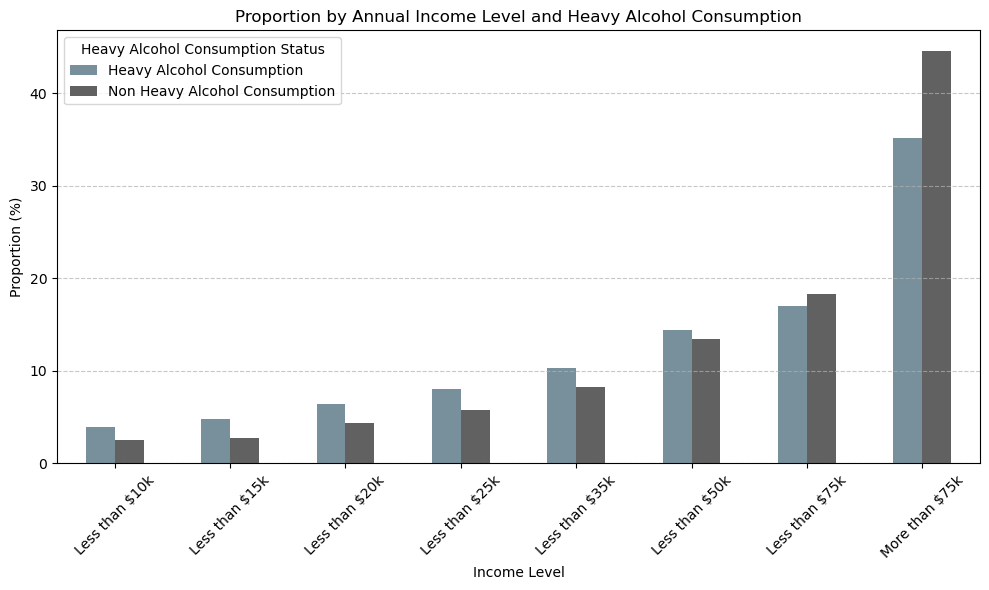

In [556]:
alcoholstack_income = alcoholstack_income.pivot(index='Income', columns='HvyAlcoholConsump', values='proportion')

# Rename columns for clarity
alcoholstack_income.columns = ['Heavy Alcohol Consumption', 'Non Heavy Alcohol Consumption']

# Plot the bar graph
fig, ax = plt.subplots(figsize=(10, 6))
alcoholstack_income.plot(kind='bar', ax=ax, color=['#78909c', '#616161'])

# Formatting
plt.title('Proportion by Annual Income Level and Heavy Alcohol Consumption')
plt.xlabel('Income Level')
plt.ylabel('Proportion (%)')
plt.xticks(rotation=0)  # Rotate x labels to horizontal
ax.set_xticklabels(['Less than $10k', 'Less than $15k', 'Less than $20k', 'Less than $25k', 'Less than $35k', 'Less than $50k', 'Less than $75k', 'More than $75k'], rotation=45)
plt.legend(title='Heavy Alcohol Consumption Status')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

In [544]:
#Heavy Alcohol Consumption and Age

alcohol_vs_diabetes_age = df_trimmed.groupby(["HvyAlcoholConsump", "Age"]).size().reset_index(name='count')
alcohol_vs_diabetes_age

# Separate 0 Heavy Alcohol Consumption values from 1 Heavy Alcohol Consumption values
no_alc_age = alcohol_vs_diabetes_age[alcohol_vs_diabetes_age["HvyAlcoholConsump"] == 0].copy()
yes_alc_age = alcohol_vs_diabetes_age[alcohol_vs_diabetes_age["HvyAlcoholConsump"] == 1].copy()

# Find the total respondents per category (Heavy Alcohol Consumption and no Heavy Alcohol Consumption)
# Create a new column for the proportion of respondents in each row out of their respective category
no_alc_sum_age = no_alc_age["count"].sum()
no_alc_age["proportion"] = (no_alc_age["count"] / no_alc_sum_age) * 100

yes_alc_sum_age = yes_alc_age["count"].sum()
yes_alc_age["proportion"] = (yes_alc_age["count"] / yes_alc_sum_age) * 100

# Using the pd.concat() function, combine the two tables into the new Heavy Alcohol Consumption df
alcoholstack_age = pd.concat([no_alc_age, yes_alc_age], ignore_index=False)
alcoholstack_age

,HvyAlcoholConsump,Age,count,proportion
0,0.0,1.0,5259,2.196522
1,0.0,2.0,7078,2.956262
2,0.0,3.0,10445,4.362553
3,0.0,4.0,13002,5.430533
4,0.0,5.0,15245,6.367365
5,0.0,6.0,18578,7.759456
6,0.0,7.0,24595,10.272571
7,0.0,8.0,28898,12.069801
8,0.0,9.0,31365,13.100190
9,0.0,10.0,30412,12.702152


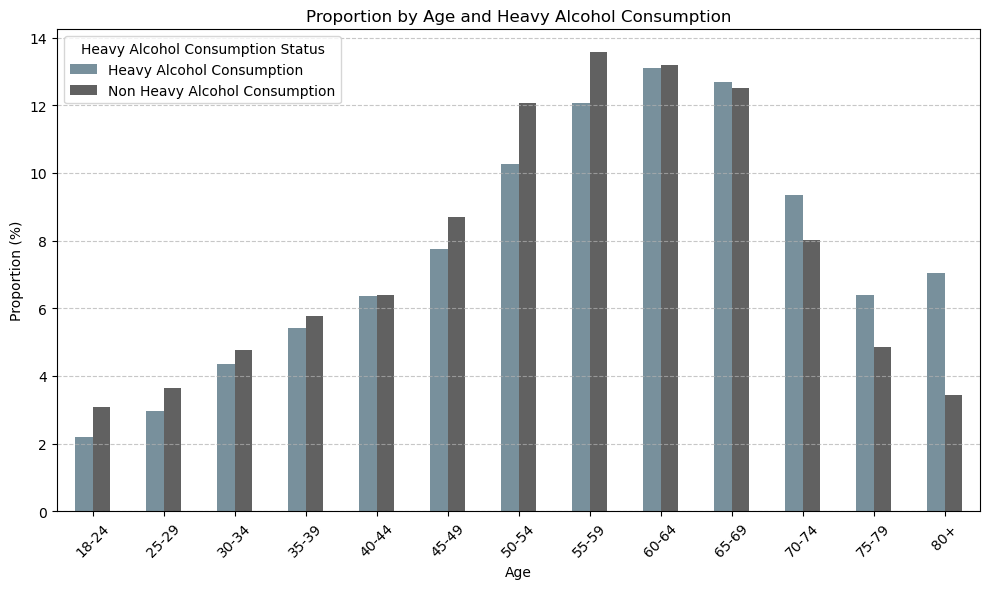

In [546]:
alcoholstack_age = alcoholstack_age.pivot(index='Age', columns='HvyAlcoholConsump', values='proportion')

# Rename columns for clarity
alcoholstack_age.columns = ['Heavy Alcohol Consumption', 'Non Heavy Alcohol Consumption']

# Plot the bar graph
fig, ax = plt.subplots(figsize=(10, 6))
alcoholstack_age.plot(kind='bar', ax=ax, color=['#78909c', '#616161'])

# Formatting
plt.title('Proportion by Age and Heavy Alcohol Consumption')
plt.xlabel('Age')
plt.ylabel('Proportion (%)')
plt.xticks(rotation=0)  # Rotate x labels to horizontal
ax.set_xticklabels(['18-24', '25-29', '30-34', '35-39', '40-44', '45-49', '50-54', '55-59', '60-64', '65-69', '70-74', '75-79', '80+' ], rotation=45)
plt.legend(title='Heavy Alcohol Consumption Status')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

In [548]:
#Heavy Alcohol Consumption to Education
alcohol_vs_diabetes_edu = df_trimmed.groupby(["HvyAlcoholConsump", "Education"]).size().reset_index(name='count')


# Separate 0 PhysActivity values from 1 PhysActivity values, copying the tables so we can easily perform actions on them
no_alc_edu = alcohol_vs_diabetes_edu[alcohol_vs_diabetes_edu["HvyAlcoholConsump"] == 0].copy()
yes_alc_edu = alcohol_vs_diabetes_edu[alcohol_vs_diabetes_edu["HvyAlcoholConsump"] == 1].copy()

# Find the total respondents per category (PhysActivity and no PhysActivity)
# Create a new column for the proportion of respondents in each row out of their respective category
no_alc_edu_sum = no_alc_edu["count"].sum()
no_alc_edu["proportion"] = (no_alc_edu["count"] / no_alc_edu_sum) * 100

yes_alc_edu_sum = yes_alc_edu["count"].sum()
yes_alc_edu["proportion"] = (yes_alc_edu["count"] / yes_alc_edu_sum) * 100

# Using the pd.concat() function, combine the two tables into the new PhysActivity df, which shows the proportions
alcoholstack_edu = pd.concat([no_alc_edu, yes_alc_edu], ignore_index=False)
alcoholstack_edu

,HvyAlcoholConsump,Education,count,proportion
0,0.0,1.0,167,0.069751
1,0.0,2.0,3938,1.644781
2,0.0,3.0,9108,3.804130
3,0.0,4.0,59439,24.825832
4,0.0,5.0,65942,27.541934
5,0.0,6.0,100830,42.113573
6,1.0,1.0,7,0.049102
7,1.0,2.0,105,0.736532
8,1.0,3.0,370,2.595398
9,1.0,4.0,3311,23.225309


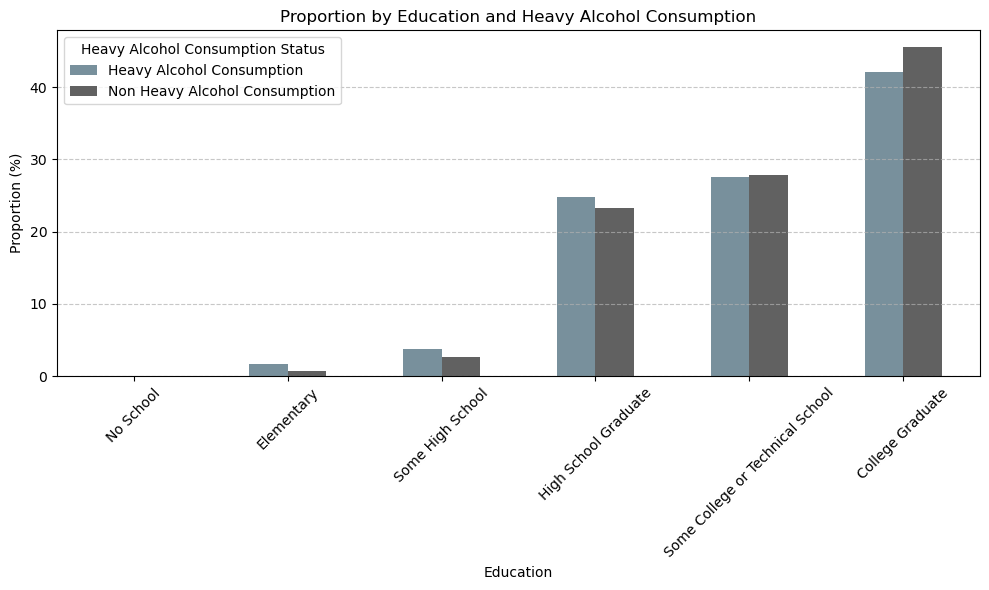

In [550]:
alcoholstack_edu = alcoholstack_edu.pivot(index='Education', columns='HvyAlcoholConsump', values='proportion')

# Rename columns for clarity
alcoholstack_edu.columns = ['Heavy Alcohol Consumption', 'Non Heavy Alcohol Consumption']

# Plot the bar graph
fig, ax = plt.subplots(figsize=(10, 6))
alcoholstack_edu.plot(kind='bar', ax=ax, color=['#78909c', '#616161'])

# Formatting
plt.title('Proportion by Education and Heavy Alcohol Consumption')
plt.xlabel('Education')
plt.ylabel('Proportion (%)')
plt.xticks(rotation=0)  # Rotate x labels to horizontal
ax.set_xticklabels(['No School', 'Elementary', 'Some High School', 'High School Graduate', 'Some College or Technical School', 'College Graduate'], rotation=45)
plt.legend(title='Heavy Alcohol Consumption Status')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

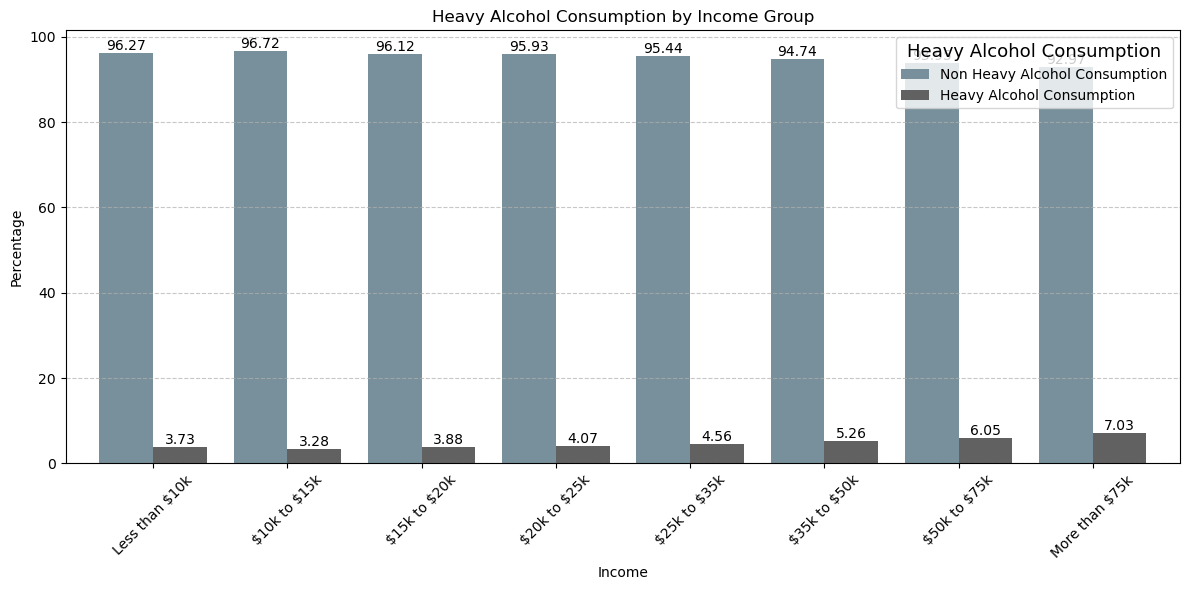

In [610]:
# Group by income and Heavy Alcohol Consumption, count the number of responses in each row
income_alc = df_trimmed.groupby(['Income', 'HvyAlcoholConsump']).size().reset_index(name='count')

# Calculate the sum of responses for each income group
income_alc_group_sum = income_alc.groupby('Income')['count'].transform('sum')

# Calculate the proportions
income_alc['proportion'] = (income_alc['count'] / income_alc_group_sum) * 100

# Pivot the table
income_alc_pivot_df = income_alc.pivot(index='Income', columns='HvyAlcoholConsump', values='proportion')

# Rename columns for easy display formatting
income_alc_pivot_df.columns = ['Non Heavy Alcohol Consumption', 'Heavy Alcohol Consumption']

# Rename indices for easy display formatting
index_mapping = {1.0: 'Less than \$10k',
                 2.0: '\$10k to \$15k',
                 3.0: '\$15k to \$20k',
                 4.0: '\$20k to \$25k',
                 5.0: '\$25k to \$35k',
                 6.0: '\$35k to \$50k',
                 7.0: '\$50k to \$75k',
                 8.0: 'More than \$75k'
                }

income_alc_pivot_df.index = income_alc_pivot_df.index.map(index_mapping)

# Plot the table
ax = income_alc_pivot_df.plot(kind='bar', width = .8, figsize=(12, 6), color=['#78909c', '#616161'] )
plt.title('Heavy Alcohol Consumption by Income Group')
plt.xlabel('Income')
plt.ylabel('Percentage')
plt.xticks(ticks=range(len(income_alc_pivot_df.index)), labels=income_alc_pivot_df.index, rotation=45)
plt.legend(title='Heavy Alcohol Consumption', title_fontsize='13')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Label the percentages?
ax.bar_label(ax.containers[0], fmt='%.2f', label_type='edge')
ax.bar_label(ax.containers[1], fmt='%.2f', label_type='edge')

# Display the plot
plt.tight_layout()
plt.savefig("images/income_vs_alc.png")
plt.show()



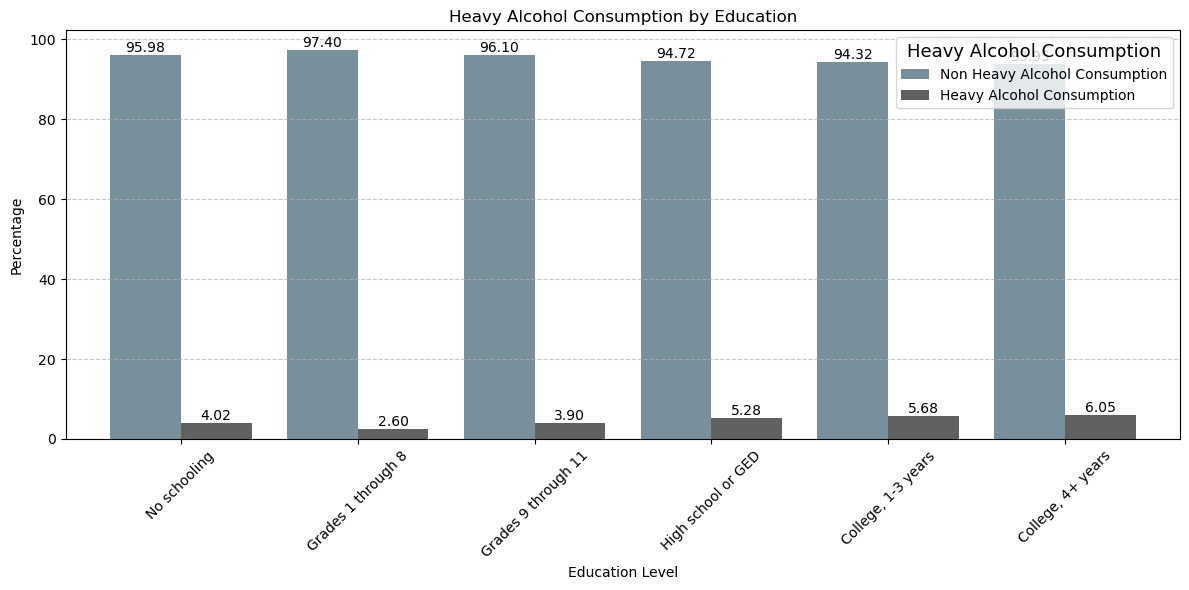

In [612]:
# Group by education and heavy alcohol consumption, count the number of responses in each row
edu_alc = df_trimmed.groupby(['Education', 'HvyAlcoholConsump']).size().reset_index(name='count')

# Calculate the sum of responses for each education group
edu_alc_group_sum = edu_alc.groupby('Education')['count'].transform('sum')

# Calculate the proportions
edu_alc['proportion'] = (edu_alc['count'] / edu_alc_group_sum) * 100

# Pivot the table
edu_alc_pivot_df = edu_alc.pivot(index='Education', columns='HvyAlcoholConsump', values='proportion')

# Rename columns for easy display formatting
edu_alc_pivot_df.columns = ['Non Heavy Alcohol Consumption', 'Heavy Alcohol Consumption']

# Rename indices for easy display formatting
index_mapping = {1.0: 'No schooling',
                 2.0: 'Grades 1 through 8',
                 3.0: 'Grades 9 through 11',
                 4.0: 'High school or GED',
                 5.0: 'College, 1-3 years',
                 6.0: 'College, 4+ years',
                }

edu_alc_pivot_df.index = edu_alc_pivot_df.index.map(index_mapping)

# Plot the table
ax = edu_alc_pivot_df.plot(kind='bar', width = .8, figsize=(12, 6), color=['#78909c', '#616161'])
plt.title('Heavy Alcohol Consumption by Education')
plt.xlabel('Education Level')
plt.ylabel('Percentage')
plt.xticks(ticks=range(len(edu_alc_pivot_df.index)), labels=edu_alc_pivot_df.index, rotation=45)
plt.legend(title='Heavy Alcohol Consumption', title_fontsize='13')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Label the percentages?
ax.bar_label(ax.containers[0], fmt='%.2f', label_type='edge')
ax.bar_label(ax.containers[1], fmt='%.2f', label_type='edge')

# Display the plot
plt.tight_layout()
plt.savefig("images/edu_vs_alc.png")
plt.show()

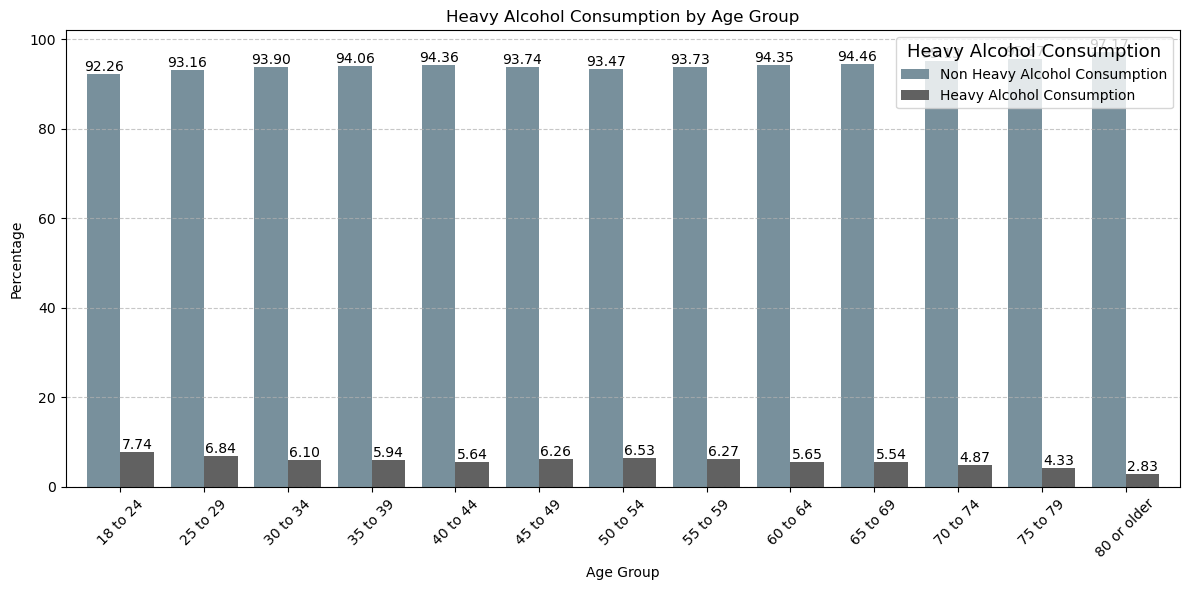

In [614]:
# Group by age and fruits, count the number of responses in each row
age_alc = df_trimmed.groupby(['Age', 'HvyAlcoholConsump']).size().reset_index(name='count')

# Calculate the sum of responses for each age group
age_alc_group_sum = age_alc.groupby('Age')['count'].transform('sum')

# Calculate the proportions
age_alc['proportion'] = (age_alc['count'] / age_alc_group_sum) * 100

# Pivot the table
age_alc_pivot_df = age_alc.pivot(index='Age', columns='HvyAlcoholConsump', values='proportion')

# Rename columns for easy display formatting
age_alc_pivot_df.columns = ['Non Heavy Alcohol Consumption', 'Heavy Alcohol Consumption']

# Rename indices for easy display formatting
index_mapping = {1.0: '18 to 24',
                 2.0: '25 to 29',
                 3.0: '30 to 34',
                 4.0: '35 to 39',
                 5.0: '40 to 44',
                 6.0: '45 to 49',
                 7.0: '50 to 54',
                 8.0: '55 to 59',
                 9.0: '60 to 64',
                 10.0: '65 to 69',
                 11.0: '70 to 74',
                 12.0: '75 to 79',
                 13.0: '80 or older'
                }

age_alc_pivot_df.index = age_alc_pivot_df.index.map(index_mapping)

# Plot the table
ax = age_alc_pivot_df.plot(kind='bar', width = .8, figsize=(12, 6), color=['#78909c', '#616161'])
plt.title('Heavy Alcohol Consumption by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Percentage')
plt.xticks(ticks=range(len(age_alc_pivot_df.index)), labels=age_alc_pivot_df.index, rotation=45)
plt.legend(title='Heavy Alcohol Consumption', title_fontsize='13')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Label the percentages?
ax.bar_label(ax.containers[0], fmt='%.2f', label_type='edge')
ax.bar_label(ax.containers[1], fmt='%.2f', label_type='edge')

# Display the plot
plt.tight_layout()
plt.savefig("images/age_vs_alc.png")
plt.show()


## Conclusions and Bonus Workspace